# Contrastive: Triplet Loss Network
Sentence-BERT embeddings, triplet margin loss (margin=1.0). 2-layer MLP maps 384d to 64d embedding. 50 epochs, lr=1e-3.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_style('whitegrid')

c:\Users\orbi8\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data and embeddings
Sentence-BERT (all-MiniLM-L6-v2) encodes each text to 384d.

In [2]:
source_path = '../../data_analysis/data.parquet'
df_raw = pd.read_parquet(source_path)

features_expanded = pd.json_normalize(df_raw['feature_cache'])
df = pd.concat([df_raw[['id', 'class', 'topic', 'text']].reset_index(drop=True),
                features_expanded[['author']].reset_index(drop=True)], axis=1)

df['label'] = (df['class'] > 1).astype(int)
print(df['class'].value_counts())

class
2    504
3    504
1    500
Name: count, dtype: int64


Compute SBERT embeddings.

In [3]:
embedder = SentenceTransformer('all-MiniLM-L6-v2', device=device)
embeddings = embedder.encode(df['text'].tolist(), show_progress_bar=True, convert_to_numpy=True)
print(f'Embeddings shape: {embeddings.shape}')

Batches: 100%|██████████| 48/48 [00:07<00:00,  6.39it/s]

Embeddings shape: (1508, 384)


Stratified train/val/test split, export IDs.

In [4]:
df['strat_key'] = df['class'].astype(str) + '_' + df['author'].astype(str)
df['embedding'] = list(embeddings)

train_val, test = train_test_split(df, test_size=0.15, stratify=df['strat_key'], random_state=42)
train, val = train_test_split(train_val, test_size=0.15/0.85, stratify=train_val['strat_key'], random_state=42)

print(f'Train: {len(train)}, Val: {len(val)}, Test: {len(test)}')

train[['id', 'class', 'topic', 'author']].to_parquet('train.parquet', index=False)
val[['id', 'class', 'topic', 'author']].to_parquet('validate.parquet', index=False)
test[['id', 'class', 'topic', 'author']].to_parquet('test.parquet', index=False)

Train: 1054, Val: 227, Test: 227


## Triplet mining and model
Online triplet mining - anchor, positive (same class), negative (different class).

In [5]:
class TripletDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.human_indices = self.df[self.df['label'] == 0].index.tolist()
        self.ai_indices = self.df[self.df['label'] == 1].index.tolist()
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        anchor_row = self.df.iloc[idx]
        anchor_emb = np.array(anchor_row['embedding'])
        anchor_label = anchor_row['label']
        
        if anchor_label == 0:
            pos_idx = np.random.choice([i for i in self.human_indices if i != idx])
            neg_idx = np.random.choice(self.ai_indices)
        else:
            pos_idx = np.random.choice([i for i in self.ai_indices if i != idx])
            neg_idx = np.random.choice(self.human_indices)
        
        positive_emb = np.array(self.df.iloc[pos_idx]['embedding'])
        negative_emb = np.array(self.df.iloc[neg_idx]['embedding'])
        
        return (
            torch.FloatTensor(anchor_emb),
            torch.FloatTensor(positive_emb),
            torch.FloatTensor(negative_emb),
            torch.LongTensor([anchor_label])
        )

train_dataset = TripletDataset(train)
val_dataset = TripletDataset(val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Projection head + binary classifier.

In [6]:
class ContrastiveNetwork(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=256, output_dim=128):
        super().__init__()
        self.projector = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim)
        )
        self.classifier = nn.Sequential(
            nn.Linear(output_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        projected = self.projector(x)
        projected = F.normalize(projected, p=2, dim=1)
        return projected
    
    def classify(self, x):
        projected = self.forward(x)
        return self.classifier(projected).squeeze()

model = ContrastiveNetwork().to(device)

Triplet loss + BCE, Adam lr=1e-3.

In [7]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.5):
        super().__init__()
        self.margin = margin
    
    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

triplet_loss_fn = TripletLoss(margin=0.5)
bce_loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [8]:
epochs = 50
best_val_auc = 0
best_state = None
history = {'train_loss': [], 'val_auc': []}

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for anchor, positive, negative, labels in train_loader:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        labels = labels.float().to(device).squeeze()
        
        optimizer.zero_grad()
        
        anchor_proj = model(anchor)
        positive_proj = model(positive)
        negative_proj = model(negative)
        
        t_loss = triplet_loss_fn(anchor_proj, positive_proj, negative_proj)
        
        preds = model.classify(anchor)
        c_loss = bce_loss_fn(preds, labels)
        
        loss = t_loss + c_loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    model.eval()
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for anchor, _, _, labels in val_loader:
            anchor = anchor.to(device)
            probs = model.classify(anchor).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.numpy().flatten())
    
    val_auc = roc_auc_score(all_labels, all_probs)
    
    history['train_loss'].append(total_loss / len(train_loader))
    history['val_auc'].append(val_auc)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = model.state_dict().copy()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Val AUC: {val_auc:.4f}')

print(f'\nBest Val AUC: {best_val_auc:.4f}')
model.load_state_dict(best_state)

Epoch 10/50 | Loss: 0.0662 | Val AUC: 0.9943
Epoch 20/50 | Loss: 0.0404 | Val AUC: 0.9899
Epoch 30/50 | Loss: 0.0036 | Val AUC: 0.9918
Epoch 40/50 | Loss: 0.0004 | Val AUC: 0.9925
Epoch 50/50 | Loss: 0.0002 | Val AUC: 0.9925

Best Val AUC: 0.9943


<All keys matched successfully>

Loss and AUC curves.

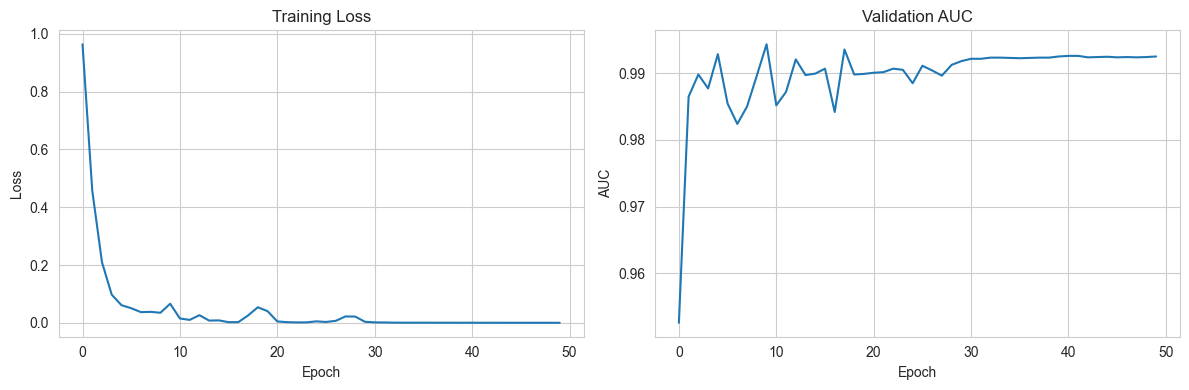

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'])
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')

axes[1].plot(history['val_auc'])
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Validation AUC')

plt.tight_layout()
plt.show()

## Distance analysis and classification
Embedding distances as features for threshold-based classification.

  File "c:\Users\orbi8\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "c:\Users\orbi8\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "c:\Users\orbi8\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\orbi8\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\orbi8\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


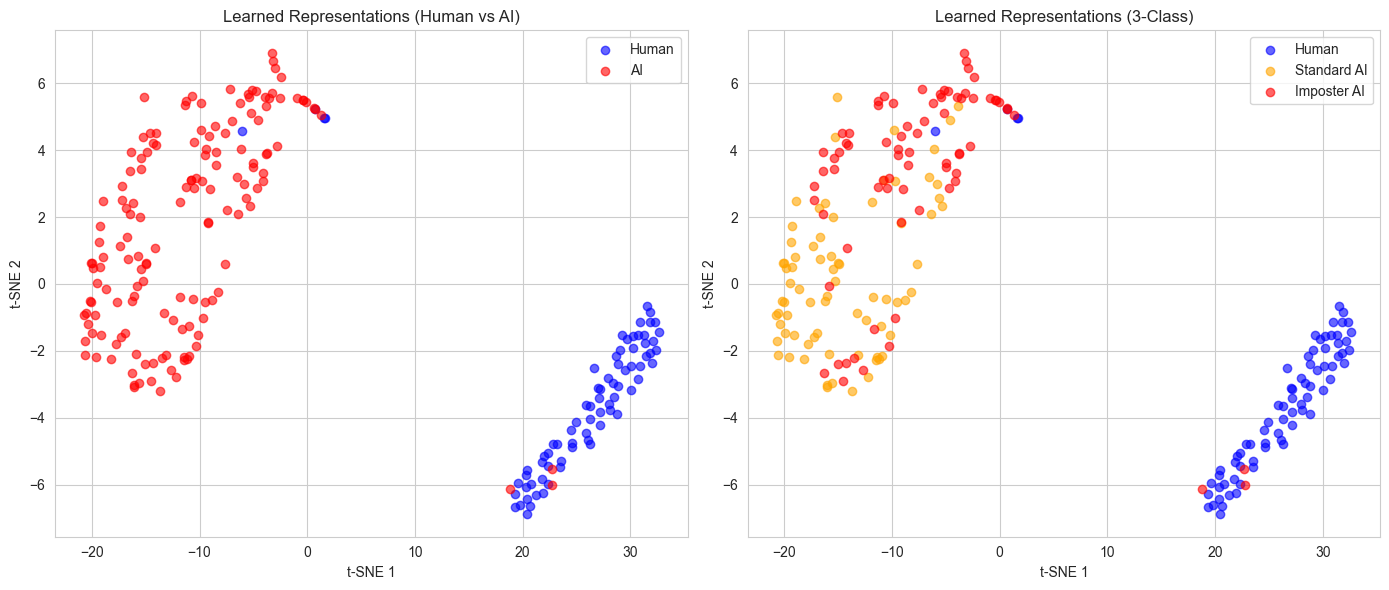

In [10]:
model.eval()
all_embeddings = np.stack(val['embedding'].values)

with torch.no_grad():
    projected = model(torch.FloatTensor(all_embeddings).to(device)).cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_coords = tsne.fit_transform(projected)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
colors = ['blue', 'red']
labels = ['Human', 'AI']
for i, label in enumerate([0, 1]):
    mask = val['label'].values == label
    ax1.scatter(tsne_coords[mask, 0], tsne_coords[mask, 1], c=colors[i], label=labels[i], alpha=0.6)
ax1.legend()
ax1.set_title('Learned Representations (Human vs AI)')
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')

ax2 = axes[1]
colors3 = ['blue', 'orange', 'red']
labels3 = ['Human', 'Standard AI', 'Imposter AI']
for i, cls in enumerate([1, 2, 3]):
    mask = val['class'].values == cls
    ax2.scatter(tsne_coords[mask, 0], tsne_coords[mask, 1], c=colors3[i], label=labels3[i], alpha=0.6)
ax2.legend()
ax2.set_title('Learned Representations (3-Class)')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')

plt.tight_layout()
plt.show()

ROC curves, overall and per-topic.

Validation ROC AUC: 0.9925
Validation Accuracy: 0.9692


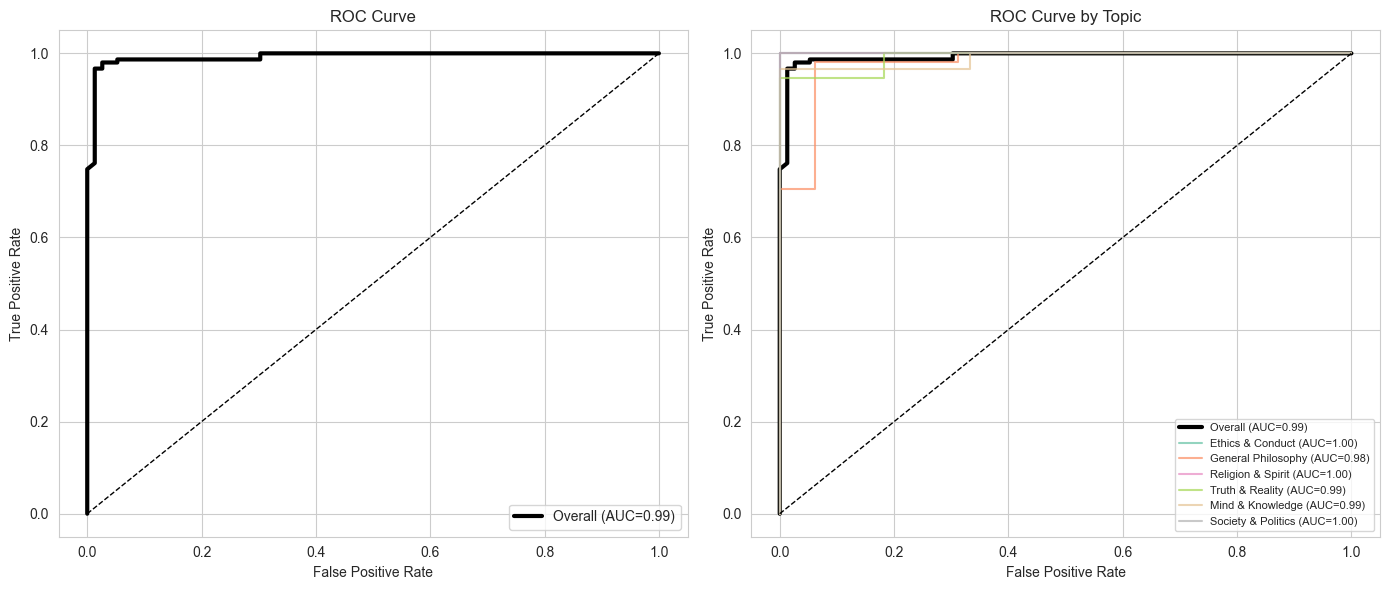

In [11]:
model.eval()
val_embeddings = np.stack(val['embedding'].values)

with torch.no_grad():
    val_probs = model.classify(torch.FloatTensor(val_embeddings).to(device)).cpu().numpy()

val_results = val.copy().reset_index(drop=True)
val_results['prob_ai'] = val_probs
val_results['pred'] = (val_probs > 0.5).astype(int)
val_results['actual_binary'] = val_results['label']

auc = roc_auc_score(val_results['actual_binary'], val_results['prob_ai'])
acc = accuracy_score(val_results['actual_binary'], val_results['pred'])
print(f'Validation ROC AUC: {auc:.4f}')
print(f'Validation Accuracy: {acc:.4f}')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

fpr, tpr, _ = roc_curve(val_results['actual_binary'], val_results['prob_ai'])

ax1 = axes[0]
ax1.plot(fpr, tpr, 'k-', lw=3, label=f'Overall (AUC={auc:.2f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')

ax2 = axes[1]
ax2.plot(fpr, tpr, 'k-', lw=3, label=f'Overall (AUC={auc:.2f})')

colors_t = plt.cm.Set2(np.linspace(0, 1, len(val_results['topic'].unique())))
for i, topic in enumerate(val_results['topic'].unique()):
    mask = val_results['topic'] == topic
    if mask.sum() > 5:
        y_true_sub = val_results[mask]['actual_binary']
        y_prob_sub = val_results[mask]['prob_ai']
        if len(y_true_sub.unique()) > 1:
            fpr_sub, tpr_sub, _ = roc_curve(y_true_sub, y_prob_sub)
            auc_sub = roc_auc_score(y_true_sub, y_prob_sub)
            ax2.plot(fpr_sub, tpr_sub, color=colors_t[i], lw=1.5, alpha=0.7,
                     label=f'{topic} (AUC={auc_sub:.2f})')

ax2.plot([0, 1], [0, 1], 'k--', lw=1)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve by Topic')
ax2.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Test set

In [12]:
imposter_mask = val_results['class'] == 3
standard_ai_mask = val_results['class'] == 2
human_mask = val_results['class'] == 1

print('Average P(AI) by class:')
print(f'  Human: {val_results.loc[human_mask, "prob_ai"].mean():.3f}')
print(f'  Standard AI: {val_results.loc[standard_ai_mask, "prob_ai"].mean():.3f}')
print(f'  Imposter AI: {val_results.loc[imposter_mask, "prob_ai"].mean():.3f}')

Average P(AI) by class:
  Human: 0.052
  Standard AI: 1.000
  Imposter AI: 0.960


Misclassified samples.

In [13]:
val_results['error_type'] = 'Correct'
val_results.loc[(val_results['actual_binary'] == 0) & (val_results['pred'] == 1), 'error_type'] = 'Human→AI (FP)'
val_results.loc[(val_results['actual_binary'] == 1) & (val_results['pred'] == 0), 'error_type'] = 'AI→Human (FN)'

print('Error Distribution:')
print(val_results['error_type'].value_counts())

fp_samples = val_results[val_results['error_type'] == 'Human→AI (FP)'].head(3)
fn_samples = val_results[val_results['error_type'] == 'AI→Human (FN)'].head(3)

print('\n' + '='*60)
print('HUMANS MISCLASSIFIED AS AI:')
print('='*60)
for idx, row in fp_samples.iterrows():
    print(f'\nID: {row["id"]}, Author: {row["author"]}, P(AI): {row["prob_ai"]:.3f}')
    print(f'Text: {row["text"][:400]}...')

print('\n' + '='*60)
print('AI MISCLASSIFIED AS HUMAN:')
print('='*60)
for idx, row in fn_samples.iterrows():
    print(f'\nID: {row["id"]}, Class: {row["class"]}, P(AI): {row["prob_ai"]:.3f}')
    print(f'Text: {row["text"][:400]}...')

Error Distribution:
error_type
Correct          220
Human→AI (FP)      4
AI→Human (FN)      3
Name: count, dtype: int64

HUMANS MISCLASSIFIED AS AI:

ID: 13ab257b-853b-40b2-993a-19cc0a1dcde6, Author: James, P(AI): 0.970
Text: Even whilst admitting that spiritualism and materialism make different prophecies of the world's future, you may yourselves pooh-pooh the difference as something so infinitely remote as to mean nothing for a sane mind. The essence of a sane mind, you may say, is to take shorter views, and to feel no concern about such chimaeras as the latter end of the world. Well, I can only say that if you say t...

ID: b8644e72-8684-474a-9f37-cbc5cf288b22, Author: Russell, P(AI): 0.933
Text: How are we to know, in a given case, that our belief is not erroneous? This is a question of the very greatest difficulty, to which no completely satisfactory answer is possible. There is, however, a preliminary question which is rather less difficult, and that is: What do we mean by truth 

Test set evaluation and confusion matrix.

Test ROC AUC: 0.9890
Test Accuracy: 0.9515


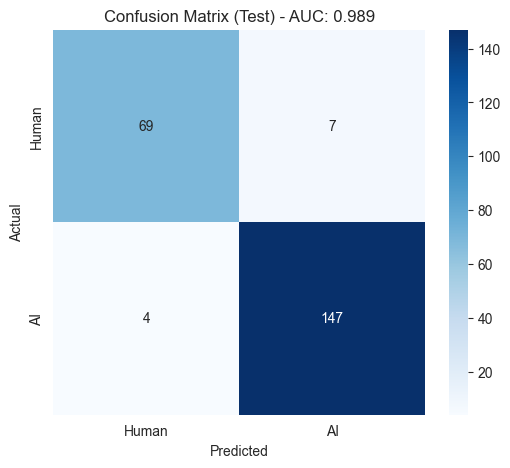

In [14]:
test_embeddings = np.stack(test['embedding'].values)

with torch.no_grad():
    test_probs = model.classify(torch.FloatTensor(test_embeddings).to(device)).cpu().numpy()

test_labels = test['label'].values
test_preds = (test_probs > 0.5).astype(int)

test_auc = roc_auc_score(test_labels, test_probs)
test_acc = accuracy_score(test_labels, test_preds)
print(f'Test ROC AUC: {test_auc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

cm = confusion_matrix(test_labels, test_preds)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix (Test) - AUC: {test_auc:.3f}')
plt.show()